<a href="https://colab.research.google.com/github/pmj-chosim/Commit-Project-2023.1.20-2023.2.28-/blob/main/2023.02.10/fmri/dnnwsp_hsp_tensorflow_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction of emotion prediction study 


An artificial neural network with multiple hidden layers (known as a deep neural network, or DNN) was employed as a predictive model (DNNp) to predict emotional responses using whole-brain functional magnetic resonance imaging (fMRI) data from individual subjects (Kim et al., NeuroImage 2019). During fMRI data acquisition, 10 healthy participants listened to 80 International Affective Digital Sound stimuli and rated their own emotions generated by each sound stimulus in terms of the arousal, dominance, and valence dimensions. The whole-brain spatial patterns from a general linear model (i.e., beta-valued maps) for each sound stimulus and the emotional response ratings were used as the input and output for the DNNp, respectively.

<!DOCTYPE html>
<html>

<head>
    <meta charset="utf-8" />
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1">
</head>

<body>
    <img src="https://drive.google.com/uc?export=view&id=1GzQBO1ry4XtrnaLjdG4kShSIqb1UuJKy">
</body>

</html>
  
Figure 1. (a) The task paradigm for each trial includes the participants listening to the sound stimulus followed by rating their emotional response for arousal, dominance, and valence via the SAMs with a nine-point scale. (b) Illustration of DNNP training used to predict the rated emotional responses using whole-brain beta-valued maps from the GLM derived from the affective sound phases. (c) Illustration of the nested five-fold CV procedure (see “Emotion prediction using a DNN-based predictive model (DNNP) in a nested five-fold cross-validation framework” in the Methods section for further details). GLM: general linear model. SAM: self-assessment manikin. SVMP: support vector machine based predictive model. CV: cross-validation.

Kim, H.C., Bandettini, P.A. and Lee, J.H., 2019. Deep neural network predicts emotional responses of the human brain from functional magnetic resonance imaging. NeuroImage, 186, pp.607-627.

# 2-0. Mounting Google drive to save the results


In [ ]:
# The directory in Google drive that you want to save the results at
gdrive_dir = '/2023_Winter_BootCamp/Regression_of_fMRI_volume'

from google.colab import drive
drive.mount('/content/drive')

import os

if not os.path.exists('/content/drive/My Drive'+gdrive_dir):
    os.makedirs('/content/drive/My Drive'+gdrive_dir)
os.chdir('/content/drive/My Drive'+gdrive_dir)

    
datapath = ('/content/drive/My Drive'+gdrive_dir)

print(datapath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/2023_Winter_BootCamp/Regression_of_fMRI_volume


# 2-1. Input data


In [ ]:
if not os.path.exists('/content/drive/My Drive'+gdrive_dir+'/Regression_of_fMRI_volume.zip'):
    !pip install pydrive
    print('\n\n')
    from pydrive.auth import GoogleAuth 
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    
    # Downloading the data from Google drive link 
    data_zip = drive.CreateFile({'id':'1r98uL-sRCRULaBZDqLFCxyY68hpgrZ8c'})
    data_zip.GetContentFile('Regression_of_fMRI_volume.zip') 
    !unzip -j Regression_of_fMRI_volume.zip

    print('\n ==> Succesfully downloaded and unzipped the data')
    
else: 
    print('\n ==> Data have already been downloaded')


 ==> Data have already been downloaded


In this tutorial, we are going to use a single-subject dataset including 80 beta value maps and valence scores 

In [ ]:
# !pip install matplotlib --upgrade
# !pip install nibabel --upgrade
!pip install nilearn

from IPython.display import Image 
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
import nilearn

# Set data path 
beta_filename = 'beta_maps_80trials.nii'

from nilearn import image

# Load a Niimg-like object from filenames or list of filenames.
# beta_maps_80trials.nii is 4D data [x, y, z, number of samples]

print(image.load_img(beta_filename).shape)
[xdim, ydim, zdim, tdim] = image.load_img(beta_filename).shape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
(53, 63, 46, 80)


We can retrieve the first volume (note that Python indexing starts at i):

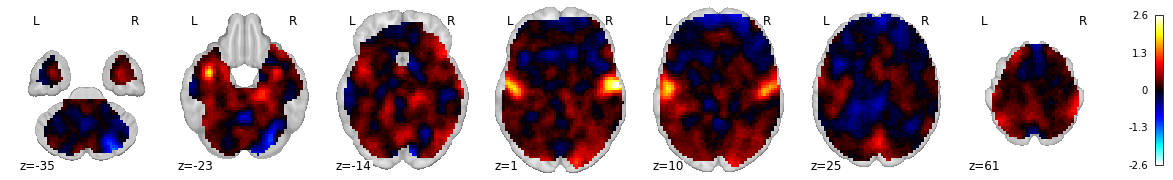

In [ ]:
# from nilearn import plotting
from nilearn import plotting
%matplotlib inline

# Indexes into a 4D Niimg-like object in the fourth dimension.
# Common use cases include extracting a 3D image out of img or
# creating a 4D image whose data is a subset of img data.
# Result can be nibabel.Nifti1Image or the input, as-is. 
# It is guaranteed that the returned object has get_data() and affine attributes.

image_mem = image.index_img(beta_filename,1)
# Arrays should be passed in numpy convention: (x, y, z) ordered.
# For visualization, non-finite values found in passed ‘stat_map_img’ or ‘bg_img’ are set to zero.
plotting.plot_stat_map(image_mem,display_mode="z")

## 2-1-1.Generating a binary mask using all samples

<ipython-input-5-648ccc5e2fd0>:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mat3d = image_mem.get_data()


(55417,)
save a binary mask!


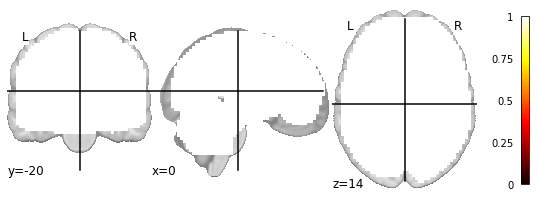

In [ ]:
import nibabel as nib
#  Generating a 4-D empty tensor to store binary maps from the sample data
stack_mat3d = np.zeros((xdim,ydim,zdim,tdim))

for ii in range(tdim):
    # Retrieve every sample data from nii file and get as 3D array
    image_mem = image.index_img(beta_filename, ii)
    mat3d = image_mem.get_data()
    
    # Extracting nonzero values in the whole brain, corresponding indices are being 1
    mat3d[np.nonzero(mat3d)] = 1
    stack_mat3d[:,:,:,ii] = mat3d

# sum up across voulmes, trials or  samples
# xdim: axis=0, ydim: axis=1, zdim: axis=2, tdim: axis=3
sum_stack_mat3d = np.sum(stack_mat3d,axis=3) [0: ]
sum_stack_mat3d.shape

# Intuitively, np.where is like asking "tell me where in this array, entries satisfy a given condition".
# Finding only voxels whose value is equal to the number of volumes, trials or samples 
map_index = np.where(sum_stack_mat3d==tdim)
print(map_index[0].shape)

# Generating a binary mask using index information 
mask_map = np.zeros((xdim,ydim,zdim))
mask_map[map_index] = 1

# Check the 3D binary mask using a NiBabel function
mask_map_mem = nib.Nifti1Image(mask_map,image_mem.affine)

plotting.plot_stat_map(mask_map_mem)

# Saving this mask image to a NIFIT file
nib.save(mask_map_mem,'mask_map.nii')
print('save a binary mask!')

## 2-1-2. Making a 2-D matrix for DNN input, and spliting training and test dataset

In [ ]:
# Deep neural networks such feedforward neuronal network, autoencoder, and so on typically uses a 2-D matrix form
# as input data. Thus, using index information from the binary mask, we can generate 2-D matrix from the sample data

# Generate a empty 2D matrix whose dimension is the number of samples x the number of in-brain voxels, [80 x 55417]
mat2d = np.zeros((tdim,map_index[0].shape[0]))

for ii in range(tdim):
    # Retrieve every sample data from nii file and get as 3D array
    image_mem = image.index_img(beta_filename, ii)
    mat3d = image_mem.get_data()
    # Only extracting beta values within the in-brain part using the index information
    mat2d[ii,:] = mat3d[map_index]

print(mat2d.shape)


# The module for file input and output
import scipy.io as sio
import scipy.stats # This module contains a large number of probability distributions as well as a growing library of statistical functions.

load_emot_resp_data = sio.loadmat('sample_valence.mat') 

valence_score = load_emot_resp_data['Y']

# z-score for each sample
z_mat2d = scipy.stats.zscore(mat2d,axis=1,ddof=1)
   
# Cross validation 
nfld = 5; #
nsample_nfld = int(tdim/nfld)

# Here, we simply select brain maps from the first one as training data set
train_x = z_mat2d[0:nsample_nfld*4,:]; train_y = valence_score[0:nsample_nfld*4,:]
print(train_x.shape)
print(train_y.flatten())

# Remaining samples are selected as test data set
test_x = z_mat2d[nsample_nfld*4:tdim,:]; test_y = valence_score[nsample_nfld*4:tdim,:]

print(test_x.shape)
print(test_y.flatten())

sio.savemat("emt_valence_sample_zscore.mat", 
            mdict={'train_x':train_x, 'train_y':train_y, 'test_x': test_x,'test_y':test_y})

print('saved "train and test data as a "mat" file!')

<ipython-input-6-d9b77d57ffe8>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mat3d = image_mem.get_data()


(80, 55417)
(64, 55417)
[3. 5. 2. 2. 5. 5. 2. 5. 3. 2. 8. 2. 7. 4. 5. 7. 2. 5. 5. 3. 2. 5. 4. 7.
 3. 8. 3. 5. 7. 4. 2. 3. 5. 5. 5. 5. 5. 7. 2. 4. 7. 5. 5. 5. 7. 6. 2. 5.
 5. 6. 5. 5. 4. 5. 4. 5. 5. 2. 5. 5. 6. 5. 4. 2.]
(16, 55417)
[2. 5. 5. 2. 4. 4. 2. 5. 5. 2. 4. 6. 3. 3. 6. 5.]
saved "train and test data as a "mat" file!


# 2-2. Emotion prediction using deep neural network (DNN) with weight sparsity control scheme

## 2-2-1 Import libraries

In [ ]:
# -*- coding: utf-8 -*-

# This import statement gives Python access to all of TensorFlow's classes, methods, and symbols. 
import tensorflow as tf
# The fundamental package for scientific computing with Python.
import numpy as np
# Linear algebra module for calculating L1 and L2 norm  
from numpy import linalg as LA
# To plot the results
import matplotlib.pyplot as plt
%matplotlib inline
# To check the directory when saving the results
import os.path
# The module for file input and output
import scipy.io as sio
# To measure time
import timeit
# To get date information
from datetime import datetime
from pytz import timezone
# To get hsp combination
import itertools


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()



Instructions for updating:
non-resource variables are not supported in the long term


## 2-2-2 load input data

In [ ]:
datasets = sio.loadmat('emt_valence_sample_zscore.mat')

############# emt_sample_data.mat #############
# train_x  = 64 volumes x 55417 voxels  
# train_y  = 64 volumes x 1 [valence scores for training]
# test_x  = 16 volumes x 55417 voxels
# test_y  = 16 volumes x 1 [valence scores for test]
############################################################

# the scale for the emotion response 
scale_ref = 10;

train_x = datasets['train_x']
train_y = datasets['train_y']/scale_ref

test_x = datasets['test_x']
test_y = datasets['test_y']/scale_ref

n_train_sample = train_y.shape[0];
n_test_sample = test_y.shape[0];

## 2-2-3. Define a classifier


In [ ]:
"""
To create input, output and a MLP network  
"""

def init_model(n_nodes, layer_activation):
    
    if layer_activation=='sigmoid':
        layer_activation = tf.nn.sigmoid
    elif layer_activation=='tanh':
        layer_activation = tf.nn.tanh
    elif layer_activation=='relu':
        layer_activation = tf.nn.relu


    # 'node_index' to split placeholder, for example, given hidden_nodes=[100, 100, 100], nodes_index=[0, 100, 200, 300]
    nodes_index = [int(np.sum(n_nodes[1:i+1])) for i in range(np.size(n_nodes,axis=0)-1)]

    # Make two placeholders to fill the values later when training or testing
    X = tf.placeholder(tf.float32,[None,n_nodes[0]])
    # Y = tf.placeholder(tf.float32,[None,n_nodes[-1]])
    Y = tf.placeholder(tf.float32,[None,n_nodes[-1]])

    # Create randomly initialized weight variables
    # w_init = [tf.div(tf.random_normal([n_nodes[i],n_nodes[i+1]]), tf.sqrt(float(n_nodes[i])/2)) for i in range(np.size(n_nodes,axis=0)-1)]
    w_init=[tf.random_uniform([n_nodes[i],n_nodes[i+1]], -1*tf.sqrt(6./(n_nodes[i]+n_nodes[i+1])),tf.sqrt(6./(n_nodes[i]+n_nodes[i+1]))) for i in np.arange(np.shape(n_nodes)[0]-1)]
    w = [tf.Variable(w_init[i], dtype=tf.float32) for i in range(np.size(n_nodes,axis=0)-1)]
    # Create zero initialized bias variables
    # b = [tf.Variable(tf.zeros([n_nodes[i+1]]), dtype=tf.float32) for i in range(np.size(n_nodes,axis=0)-1)]
    b=[tf.Variable(tf.zeros([n_nodes[i+1]]), dtype=tf.float32) for i in np.arange(np.shape(n_nodes)[0]-1)]
  

    # Build an MLP model
    mlp_layers=[0.0]*(np.size(n_nodes,axis=0)-1)
    for i in range(np.size(n_nodes,axis=0)-1):
        # Input layer
        if i==0:
            mlp_layers[i] = tf.add(tf.matmul(X,w[i]),b[i])
            mlp_layers[i] = layer_activation(mlp_layers[i])
        # Hidden layers
        elif i>0 and i<(np.size(n_nodes,axis=0)-1):
            mlp_layers[i] = tf.add(tf.matmul(mlp_layers[i-1],w[i]),b[i])
            mlp_layers[i] = layer_activation(mlp_layers[i])
        # Output layer
        elif i==(np.size(n_nodes,axis=0)-1):
            mlp_layers[i] = tf.add(tf.matmul(mlp_layers[i-1],w[i]),b[i])


    return nodes_index, X, Y, mlp_layers, w, b

## 2-2-4. Define training parameters


In [ ]:
"""
L1 and L2 regularization terms

""" 

def init_regularizations(mode, n_nodes, nodes_index, n_tg_hsp, w, b):

    if mode=='layer':
        # The size is same with the number of layers
        Beta = tf.placeholder(tf.float32,[n_tg_hsp])
        # Get L1 loss term by simply multiplying beta(scalar value) and L1 norm of weight for each layer
        L1_loss = [tf.reduce_sum(tf.multiply(tf.abs(w[i]),Beta[i])) for i in range(n_tg_hsp)]

    elif mode=='node':
        # The size is same with the number of nodes
        Beta = tf.placeholder(tf.float32,[np.sum(n_nodes[1:(n_tg_hsp+1)])])
        # Get L1 loss term by multiplying beta(vector values as many as n_nodes) and L1 norm of weight for each layer
        L1_loss = [tf.reduce_sum(tf.matmul(tf.abs(w[i]),\
                                     tf.reshape(Beta[nodes_index[i]:nodes_index[i+1]],[-1,1]))) for i in range(n_tg_hsp)] 

    L1_loss_total = tf.reduce_sum(L1_loss)


    L2_REG = tf.placeholder(tf.float32)
    L2_loss = [tf.reduce_sum(tf.square(w[i])) for i in range(np.size(n_nodes,axis=0)-1)]
    L2_loss_total = tf.multiply(L2_REG,tf.reduce_sum(L2_loss))

    return Beta, L1_loss_total, L2_REG, L2_loss_total


""" 
Cost term (Cost = Mean sqaured error + L1 term + L2 term ) 
"""
def init_cost(mlp_layers, Y, L1_loss_total, L2_loss_total):

    # A softmax regression : it adds up the evidence of our input being in certain classes, and converts that evidence into probabilities.
    # cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=mlp_layers[-1], labels=Y)) \
    #                         + L1_loss_total + L2_loss_total
    
    # Mean squared error
    # cost = tf.losses.mean_squared_error(Y,mlp_layers[-1]) + L1_loss_total + L2_loss_total
    cost = tf.reduce_mean(tf.squared_difference(mlp_layers[-1], Y)) + L1_loss_total + L2_loss_total
    return cost
  

""" 
Error term  
"""
def init_error(mlp_layers, Y):

    # correct_prediction = tf.equal(tf.argmax(mlp_layers[-1],1),tf.argmax(Y,1))
    # error = 1-tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
    # error = tf.losses.mean_squared_error(Y,mlp_layers[-1])
    
    error = tf.reduce_mean(tf.squared_difference(mlp_layers[-1], Y)) 
    return error


"""
TensorFlow provides optimizers that slowly change each variable in order to minimize the loss function.
"""
def init_optimizer(optimizer_algorithm, cost, momentum):
    
    Lr = tf.placeholder(tf.float32)
    
    if optimizer_algorithm=='GradientDescent':
        optimizer = tf.train.GradientDescentOptimizer(Lr).minimize(cost)
    elif optimizer_algorithm=='Adagrad':
        optimizer = tf.train.AdagradOptimizer(Lr).minimize(cost)
    elif optimizer_algorithm=='Adam':
        optimizer = tf.train.AdamOptimizer(Lr).minimize(cost)
    elif optimizer_algorithm=='Momentum':
        optimizer = tf.train.MomentumOptimizer(Lr,momentum).minimize(cost)
    elif optimizer_algorithm=='RMSProp':
        optimizer = tf.train.RMSPropOptimizer(Lr).minimize(cost)

    return Lr, optimizer



"""
Variables to store training results
"""
def init_savingVariables(n_tg_hsp):
    if mode=='layer':
        beta_val = np.zeros(n_tg_hsp)
        beta_flat = np.zeros(n_tg_hsp)
        hsp_val = np.zeros(n_tg_hsp)
        result_beta = np.zeros(n_tg_hsp)
        result_hsp = np.zeros(n_tg_hsp)

    elif mode=='node':
        beta_val = [np.zeros(n_nodes[i+1]) for i in range(n_tg_hsp)]
        beta_flat = np.zeros(np.sum(n_nodes[1:-1]))
        hsp_val = [np.zeros(n_nodes[i+1]) for i in range(n_tg_hsp)]
        result_beta = [np.zeros(n_nodes[i+1]) for i in range(n_tg_hsp)]
        result_hsp = [np.zeros(n_nodes[i+1]) for i in range(n_tg_hsp)]


    # make arrays to store and plot results
    result_lr = np.zeros(1)
    result_cost = np.zeros(1)
    result_train_err = np.zeros(1)
    result_test_err = np.zeros(1)
    
    result_train_pct=np.zeros(n_train_sample)
    result_test_pct=np.zeros(n_test_sample)
 
   

    return beta_val, beta_flat, hsp_val, result_beta, result_hsp, result_lr, result_cost, result_train_err, result_test_err, result_train_pct, result_test_pct


## 2-2-5. Define Hoyer's sparsity control function

In [ ]:
"""
Hoyer's sparsity level control
"""

def Hoyers_sparsity_control(mode, beta_lrates, W, b, max_b, tg):

    # Weight sparsity control with Hoyer's sparsness (Layer wise)
    if mode=='layer':

        # Get value of weight
        [n_nodes,dim]=W.shape
        num_elements=n_nodes*dim

        Wvec=W.flatten()

        # Calculate L1 and L2 norm
        L1=LA.norm(Wvec,1)
        L2=LA.norm(Wvec,2)

        # Calculate hoyer's sparsness
        h=(np.sqrt(num_elements)-(L1/L2))/(np.sqrt(num_elements)-1)

        # Update beta
        b-=beta_lrates*np.sign(h-tg)

        # Trim value
        b=0.0 if b<0.0 else b
        b=max_b if b>max_b else b

        return [h,b]

    # Weight sparsity control with Hoyer's sparsness (Node wise)
    elif mode=='node':

        b_vec = b

        # Get value of weight
        [n_nodes,dim]=W.shape

        # Calculate L1 and L2 norm
        L1=LA.norm(W,1,axis=0)
        L2=LA.norm(W,2,axis=0)

        h_vec = np.zeros((1,dim))
        tg_vec = np.ones(dim)*tg

        # Calculate hoyer's sparsness
        h_vec=(np.sqrt(n_nodes)-(L1/L2))/(np.sqrt(n_nodes)-1)

        # Update beta
        b_vec-=beta_lrates*np.sign(h_vec-tg_vec)

        # Trim value
        b_vec[b_vec<0.0]=0.0
        b_vec[b_vec>max_b]=max_b


        return [h_vec,b_vec]

## 2-2-6. Set hyperparameters for training


In [ ]:
""" 
Set the number of nodes for input, hidden layers and output layer
"""
n_nodes=[55417,20,20,20,1]

"""
Select the sparsity control mode
'layer' for layer wise sparsity control
'node' for node wise sparsity control
"""

mode = 'node'

# Max beta
max_beta = [0.001, 0.05, 0.05]
# Beta learning rate
beta_lr = [1e-3, 1e-2, 1e-2]

# Candidates of target sparsness level for each layer (0:dense~1:sparse)
hsp_cands = list(itertools.product([0.3, 0.7],[0.3, 0.7],[0.3, 0.7])) #[[0.8, 0.8, 0.8]]
n_hsp_cands = len(hsp_cands)


"""
Select optimizer :
    'GradientDescent'
    'Adagrad'
    'Adam'
    'Momentum'
    'RMSProp'
"""
optimizer_algorithm = 'Momentum'

momentum = 0.90


"""
Set learning hyperparameters
"""

# Total epochs
n_epochs = 300
# Mini batch size
batch_size = 2
# Initial learning rate
lr_init = 0.0005
# Learning rate anealing after **th epoch
begin_anneal = 20
# Learning rate decay rate
decay_rate = 0.00002
# Minimum learning rate
lr_min = 1e-6

# Layer activation 'sigmoid', 'tanh', 'relu'
layer_activation = 'tanh'


# Lambda for L2 regularization
L2_reg = 1e-4


"""
Set the directory to save results
"""
directory_path = os.getcwd()


"""
Set the directory to save results
"""
# Make a new results directory
dtime_utc = datetime.now(timezone('UTC'))
dtime = dtime_utc.astimezone(timezone('Asia/Seoul'))
directory_save = os.path.join(directory_path, r'results_%04d%02d%02d_%02d%02d'%(dtime.year,dtime.month,dtime.day,dtime.hour,dtime.minute))
if not os.path.exists(directory_save):
    os.makedirs(directory_save)

print('\n ==> The result directory path is '+directory_save)



 ==> The result directory path is /content/drive/My Drive/2023_Winter_BootCamp/Regression_of_fMRI_volume/results_20230207_2155


In [ ]:
n_nodes

[55417, 20, 20, 20, 1]

## 2-2-7. Create a model using definitions above


In [ ]:
nodes_index, X, Y, mlp_layers, w, b = init_model(n_nodes, layer_activation)

Beta, L1_loss_total, L2_REG, L2_loss_total = init_regularizations(mode, n_nodes, nodes_index, len(hsp_cands[0]), w, b)
cost = init_cost(mlp_layers, Y, L1_loss_total, L2_loss_total)

error = init_error(mlp_layers, Y)

Lr, optimizer = init_optimizer(optimizer_algorithm, cost, momentum)

## 2-2-8. Learning


 ****************************** Validation phase *******************************
# ( 1 / 8 ) hsp candidate : (0.3, 0.3, 0.3) #
< Epoch 50 > Cost : 5.919 / Train err : 0.057 /  Validation  err : 0.094
             beta : [0.001  0.0125 0.0275] / hsp : [0.22264029 0.29025889 0.27005416]
< Epoch 100 > Cost : 0.038 / Train err : 0.062 /  Validation  err : 0.107
             beta : [0.     0.0005 0.0005] / hsp : [0.30178149 0.30279453 0.30203981]
< Epoch 150 > Cost : 0.014 / Train err : 0.067 /  Validation  err : 0.117
             beta : [0.    0.    0.001] / hsp : [0.30131236 0.30254486 0.30156845]
< Epoch 200 > Cost : 0.015 / Train err : 0.068 /  Validation  err : 0.115
             beta : [0.     0.0015 0.0005] / hsp : [0.30111486 0.30244188 0.30136762]
< Epoch 250 > Cost : 0.017 / Train err : 0.070 /  Validation  err : 0.115
             beta : [0.     0.0005 0.    ] / hsp : [0.3010582  0.30237167 0.30121789]
< Epoch 300 > Cost : 0.016 / Train err : 0.070 /  Validation  err : 0.115
  

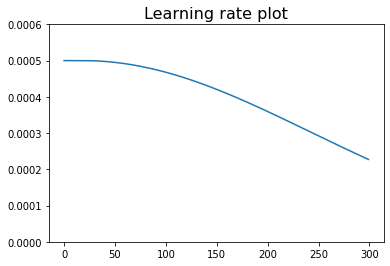

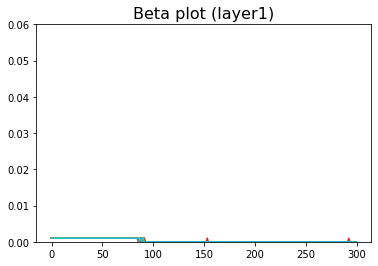

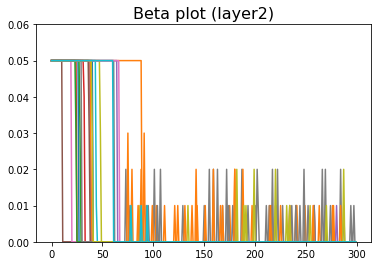

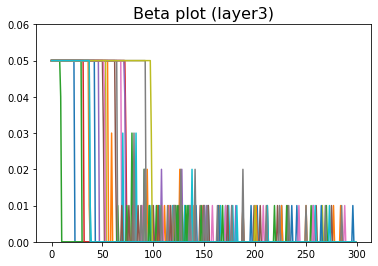

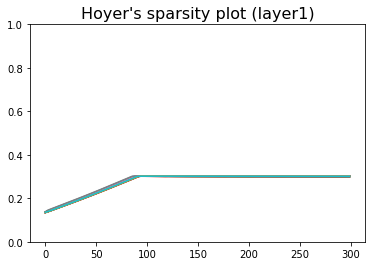

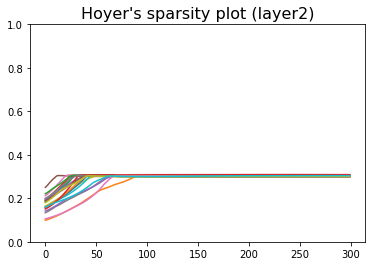

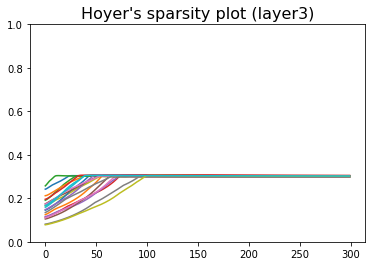

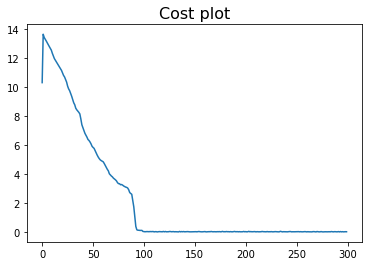

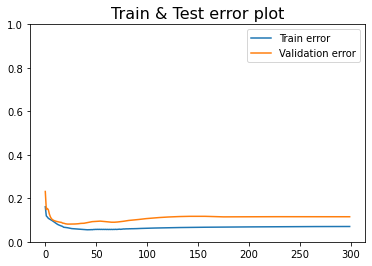

/usr/local/lib/python3.8/dist-packages/scipy/io/matlab/mio5.py:493: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)



####################################################################


==> Training has been finished!

The code ran for 0 mins



 ****************************** Validation phase *******************************
# ( 2 / 8 ) hsp candidate : (0.3, 0.3, 0.7) #
< Epoch 50 > Cost : 7.344 / Train err : 0.065 /  Validation  err : 0.103
             beta : [0.001  0.0225 0.05  ] / hsp : [0.22157747 0.28060642 0.29799719]
< Epoch 100 > Cost : 1.112 / Train err : 0.054 /  Validation  err : 0.064
             beta : [0.   0.   0.05] / hsp : [0.30174683 0.30466703 0.46971084]
< Epoch 150 > Cost : 0.294 / Train err : 0.045 /  Validation  err : 0.038
             beta : [0.     0.001  0.0395] / hsp : [0.30074118 0.30435024 0.64328946]
< Epoch 200 > Cost : 0.066 / Train err : 0.042 /  Validation  err : 0.035
             beta : [0.     0.     0.0075] / hsp : [0.30060195 0.304446   0.70051918]
< Epoch 250 > Cost : 0.020 / Train err : 0.044 /  Validation  err : 0.034
             beta : [0.    0.    0

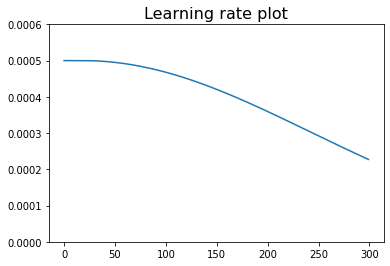

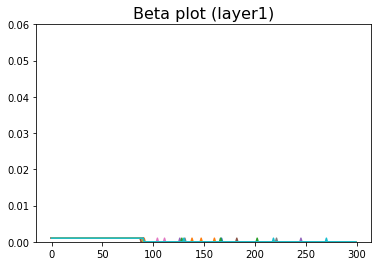

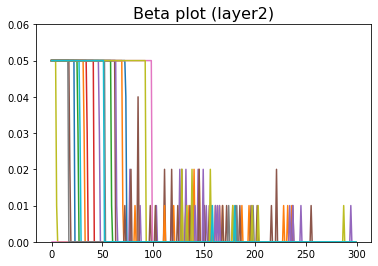

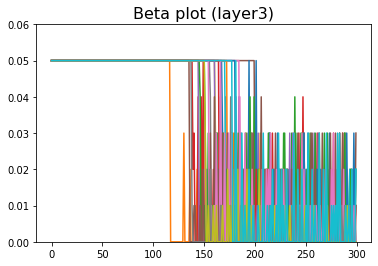

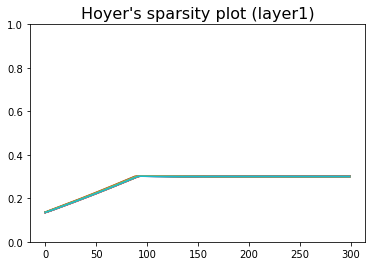

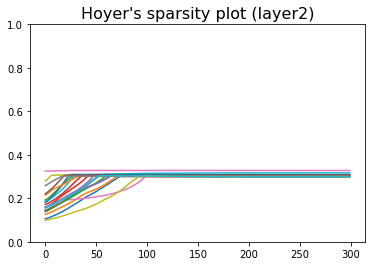

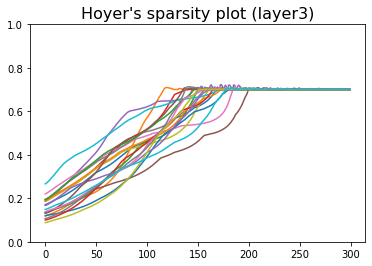

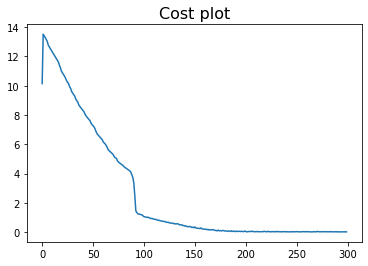

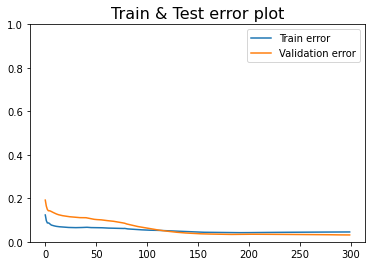


####################################################################


==> Training has been finished!

The code ran for 1 mins



 ****************************** Validation phase *******************************
# ( 3 / 8 ) hsp candidate : (0.3, 0.7, 0.3) #
< Epoch 50 > Cost : 6.940 / Train err : 0.066 /  Validation  err : 0.075
             beta : [0.001 0.05  0.02 ] / hsp : [0.22170004 0.34705055 0.28326052]
< Epoch 100 > Cost : 0.912 / Train err : 0.056 /  Validation  err : 0.053
             beta : [0.     0.0475 0.    ] / hsp : [0.30170482 0.52570238 0.30382558]
< Epoch 150 > Cost : 0.246 / Train err : 0.049 /  Validation  err : 0.038
             beta : [5.0e-05 1.8e-02 5.0e-04] / hsp : [0.30093184 0.66753472 0.30268602]
< Epoch 200 > Cost : 0.116 / Train err : 0.045 /  Validation  err : 0.030
             beta : [0.     0.0075 0.0005] / hsp : [0.30090776 0.70062087 0.30248078]
< Epoch 250 > Cost : 0.050 / Train err : 0.048 /  Validation  err : 0.029
             beta : [0.     

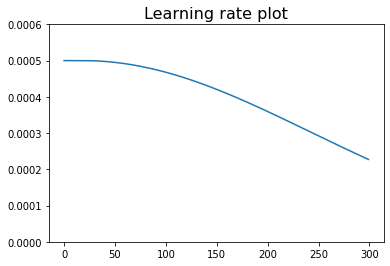

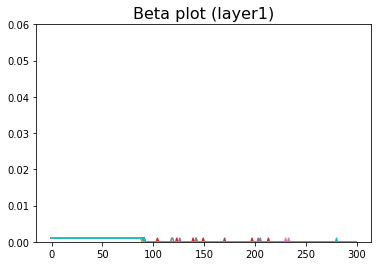

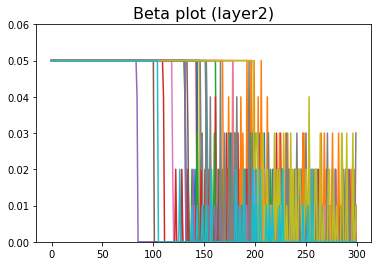

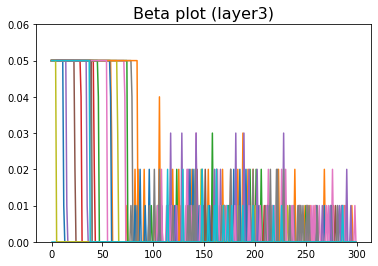

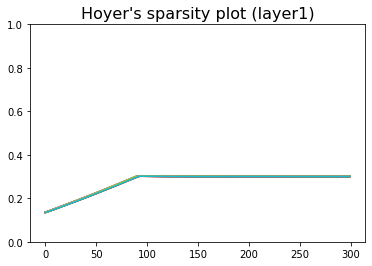

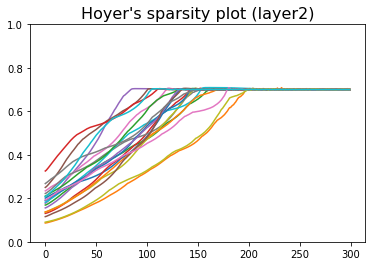

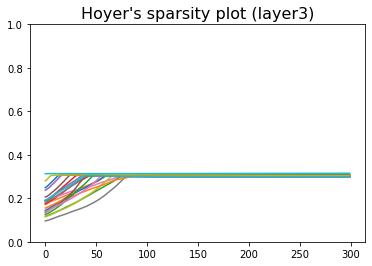

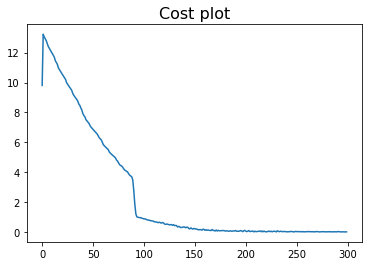

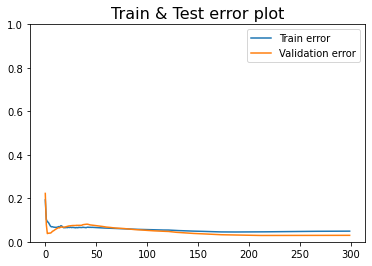


####################################################################


==> Training has been finished!

The code ran for 2 mins



 ****************************** Validation phase *******************************
# ( 4 / 8 ) hsp candidate : (0.3, 0.7, 0.7) #
< Epoch 50 > Cost : 8.268 / Train err : 0.054 /  Validation  err : 0.042
             beta : [0.001 0.05  0.05 ] / hsp : [0.22187724 0.31134656 0.32466268]
< Epoch 100 > Cost : 1.935 / Train err : 0.043 /  Validation  err : 0.029
             beta : [0.     0.0475 0.0475] / hsp : [0.30156633 0.49651401 0.50674348]
< Epoch 150 > Cost : 0.479 / Train err : 0.035 /  Validation  err : 0.021
             beta : [0.     0.0285 0.0235] / hsp : [0.30077477 0.66750149 0.65636654]
< Epoch 200 > Cost : 0.073 / Train err : 0.035 /  Validation  err : 0.021
             beta : [0.     0.0025 0.0045] / hsp : [0.30076057 0.70089125 0.70038313]
< Epoch 250 > Cost : 0.062 / Train err : 0.038 /  Validation  err : 0.022
             beta : [0.     0.0

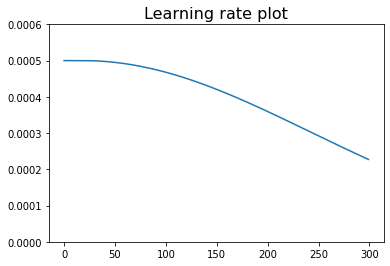

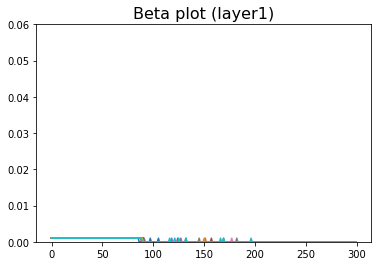

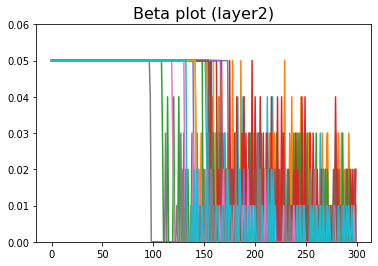

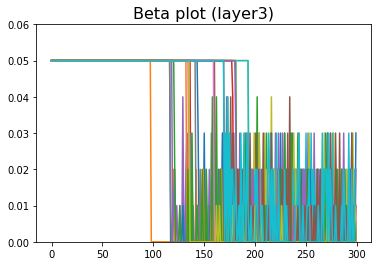

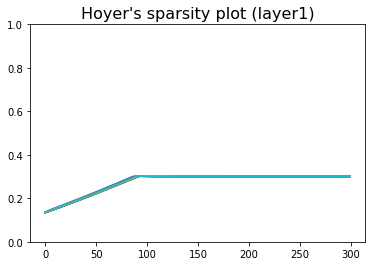

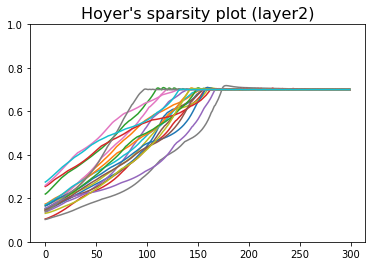

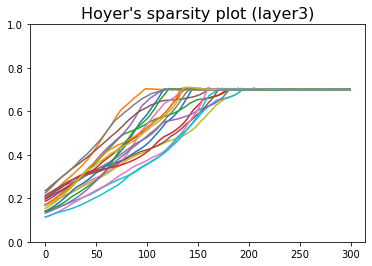

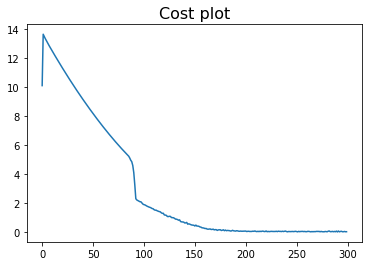

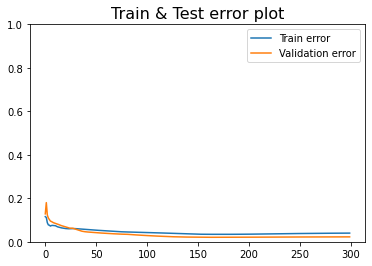


####################################################################


==> Training has been finished!

The code ran for 2 mins



 ****************************** Validation phase *******************************
# ( 5 / 8 ) hsp candidate : (0.7, 0.3, 0.3) #
< Epoch 50 > Cost : 5.022 / Train err : 0.053 /  Validation  err : 0.055
             beta : [0.001  0.008  0.0125] / hsp : [0.22046757 0.2972792  0.28973152]
< Epoch 100 > Cost : 2.340 / Train err : 0.055 /  Validation  err : 0.056
             beta : [0.001 0.    0.   ] / hsp : [0.31648388 0.30479149 0.30383071]
< Epoch 150 > Cost : 1.228 / Train err : 0.057 /  Validation  err : 0.048
             beta : [0.001 0.    0.   ] / hsp : [0.41905644 0.30470433 0.30322534]
< Epoch 200 > Cost : 0.566 / Train err : 0.058 /  Validation  err : 0.044
             beta : [0.001 0.    0.   ] / hsp : [0.52733082 0.3046409  0.30302035]
< Epoch 250 > Cost : 0.204 / Train err : 0.060 /  Validation  err : 0.047
             beta : [0.001 0.    0.  

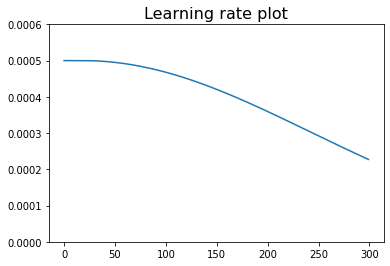

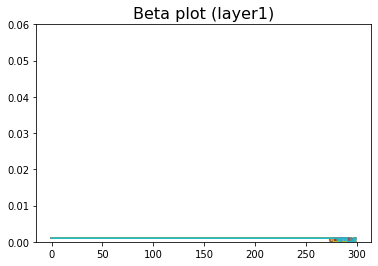

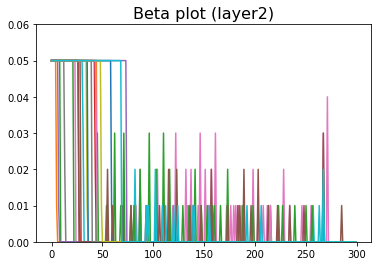

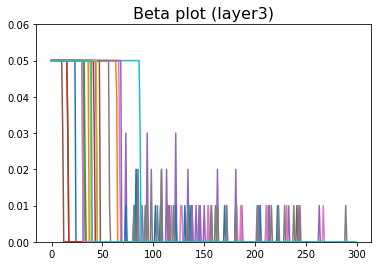

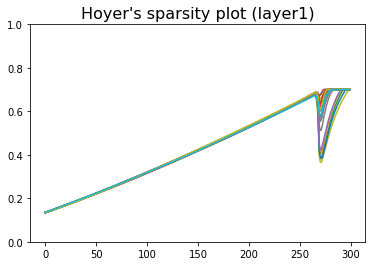

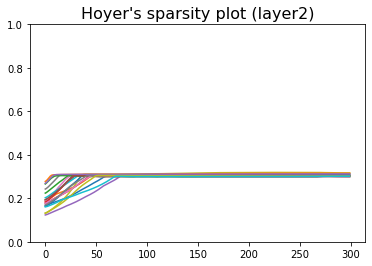

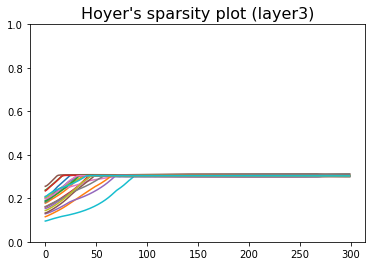

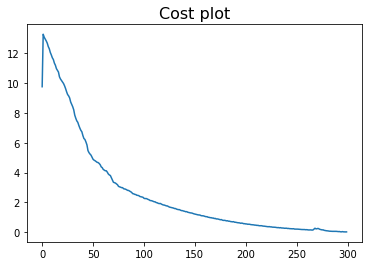

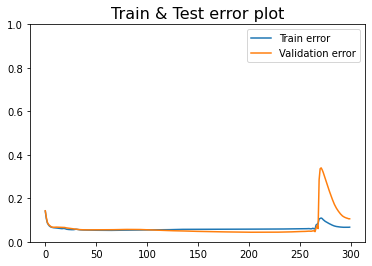


####################################################################


==> Training has been finished!

The code ran for 3 mins



 ****************************** Validation phase *******************************
# ( 6 / 8 ) hsp candidate : (0.7, 0.3, 0.7) #
< Epoch 50 > Cost : 7.201 / Train err : 0.101 /  Validation  err : 0.097
             beta : [0.001  0.0225 0.05  ] / hsp : [0.22184875 0.27918949 0.32385094]
< Epoch 100 > Cost : 3.377 / Train err : 0.078 /  Validation  err : 0.063
             beta : [0.001  0.0035 0.0475] / hsp : [0.31825093 0.30269024 0.49982333]
< Epoch 150 > Cost : 1.478 / Train err : 0.056 /  Validation  err : 0.041
             beta : [0.001  0.     0.0265] / hsp : [0.42155224 0.30356335 0.65011297]
< Epoch 200 > Cost : 0.592 / Train err : 0.053 /  Validation  err : 0.037
             beta : [0.001 0.001 0.003] / hsp : [0.53075225 0.30383797 0.70243602]
< Epoch 250 > Cost : 0.229 / Train err : 0.054 /  Validation  err : 0.037
             beta : [0.001  0.0

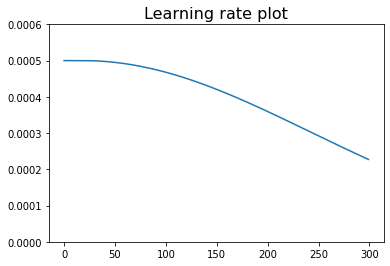

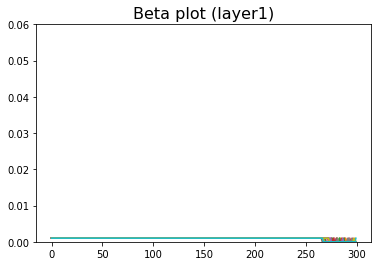

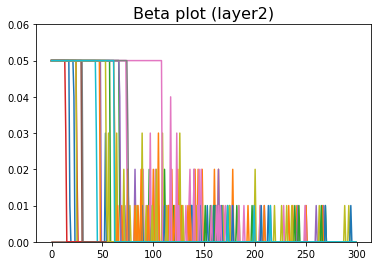

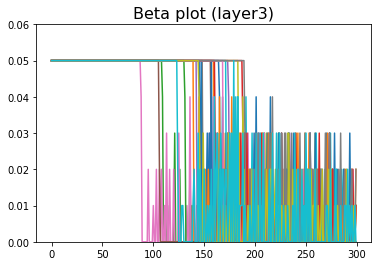

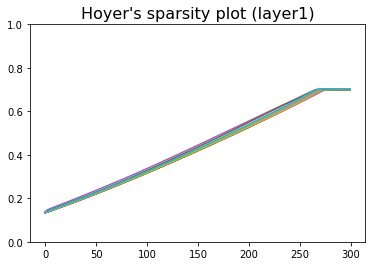

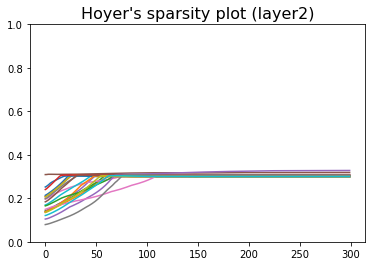

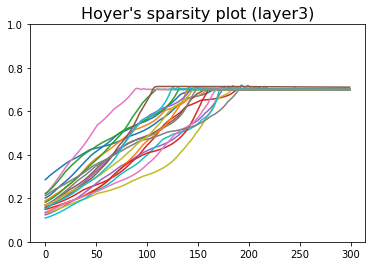

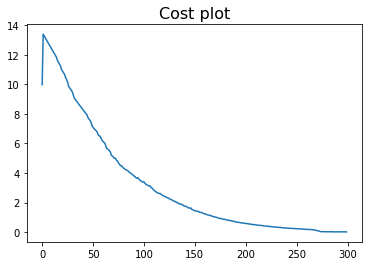

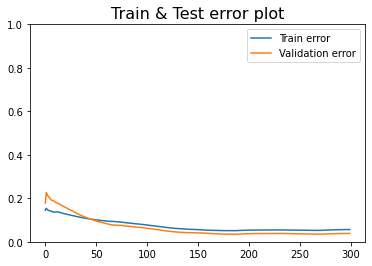


####################################################################


==> Training has been finished!

The code ran for 4 mins



 ****************************** Validation phase *******************************
# ( 7 / 8 ) hsp candidate : (0.7, 0.7, 0.3) #
< Epoch 50 > Cost : 7.605 / Train err : 0.060 /  Validation  err : 0.084
             beta : [0.001  0.05   0.0285] / hsp : [0.22310167 0.3193414  0.26979889]
< Epoch 100 > Cost : 3.346 / Train err : 0.057 /  Validation  err : 0.071
             beta : [0.001  0.0475 0.0025] / hsp : [0.31977464 0.48779246 0.30103148]
< Epoch 150 > Cost : 1.445 / Train err : 0.047 /  Validation  err : 0.047
             beta : [0.001  0.0205 0.0015] / hsp : [0.42374177 0.65556282 0.30188885]
< Epoch 200 > Cost : 0.603 / Train err : 0.043 /  Validation  err : 0.042
             beta : [0.001  0.005  0.0005] / hsp : [0.53418382 0.70073048 0.30156231]
< Epoch 250 > Cost : 0.241 / Train err : 0.045 /  Validation  err : 0.044
             beta : [0.001  

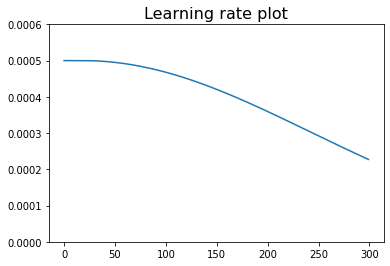

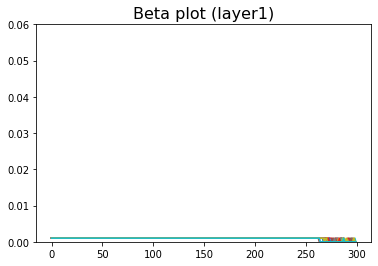

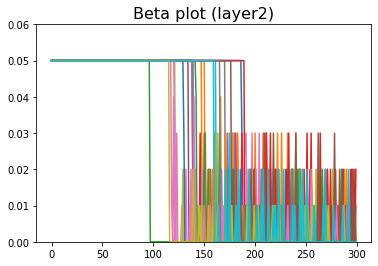

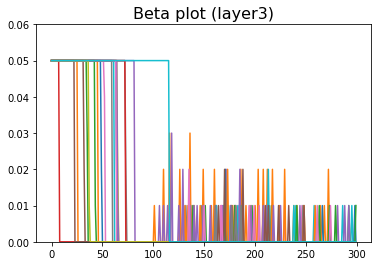

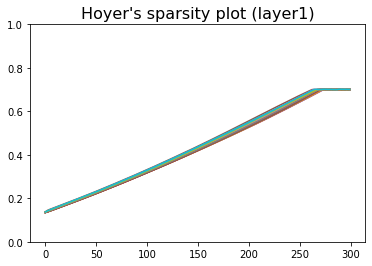

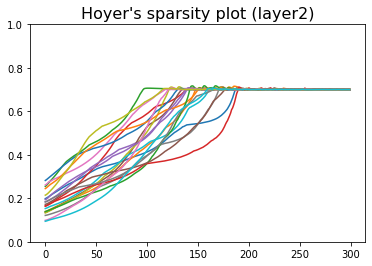

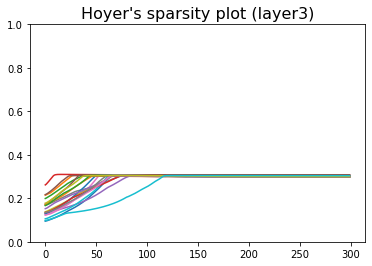

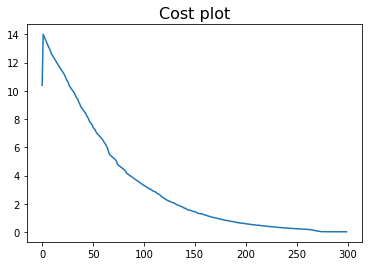

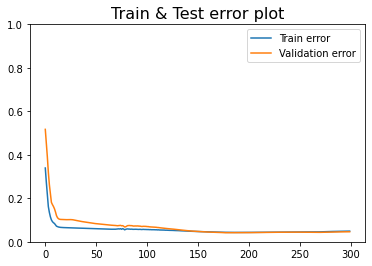


####################################################################


==> Training has been finished!

The code ran for 4 mins



 ****************************** Validation phase *******************************
# ( 8 / 8 ) hsp candidate : (0.7, 0.7, 0.7) #
< Epoch 50 > Cost : 8.373 / Train err : 0.059 /  Validation  err : 0.039
             beta : [0.001 0.05  0.05 ] / hsp : [0.22283363 0.32584402 0.30051281]
< Epoch 100 > Cost : 4.388 / Train err : 0.042 /  Validation  err : 0.028
             beta : [0.001 0.05  0.05 ] / hsp : [0.31945771 0.47619795 0.47311716]
< Epoch 150 > Cost : 1.737 / Train err : 0.034 /  Validation  err : 0.022
             beta : [0.001 0.037 0.028] / hsp : [0.42299638 0.65024697 0.65332512]
< Epoch 200 > Cost : 0.622 / Train err : 0.034 /  Validation  err : 0.021
             beta : [0.001 0.007 0.001] / hsp : [0.53323773 0.70044942 0.70070349]
< Epoch 250 > Cost : 0.273 / Train err : 0.036 /  Validation  err : 0.022
             beta : [0.001  0.0045 0.003

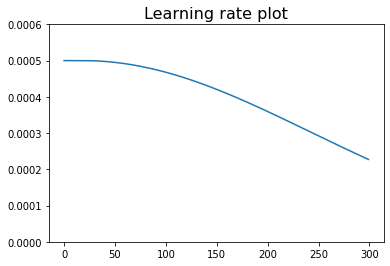

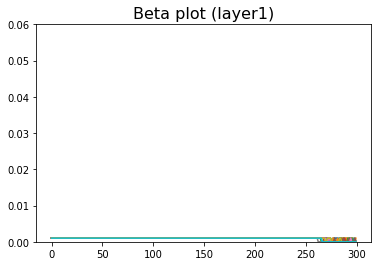

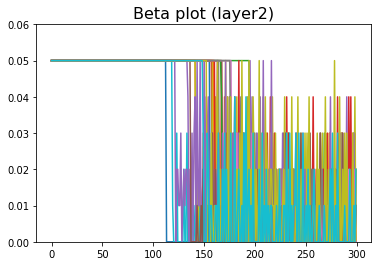

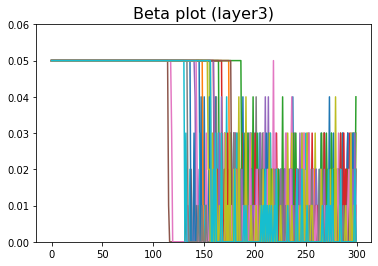

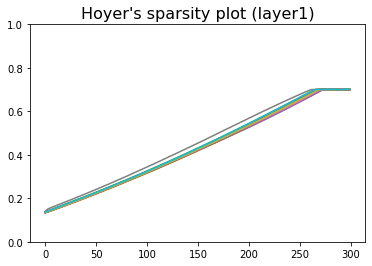

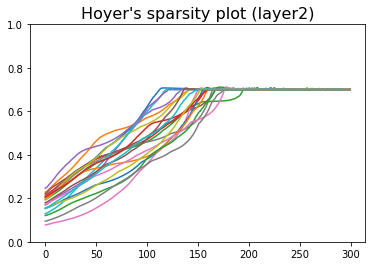

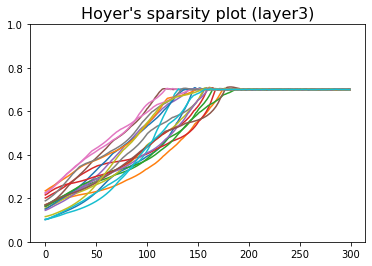

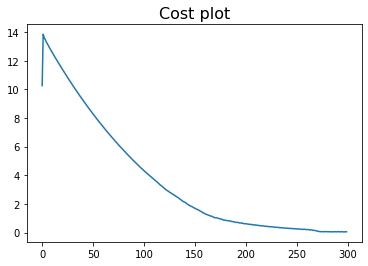

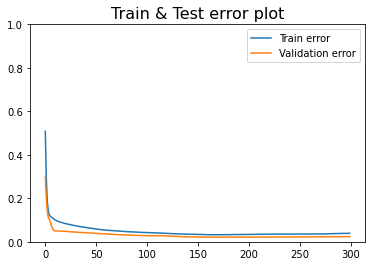


####################################################################


==> Training has been finished!

The code ran for 5 mins



 ****************************** Test phase *******************************
############### ==> Selected hsp : (0.3, 0.7, 0.7) ###############
< Epoch 50 > Cost : 0.066 / Train err : 0.029 /  Test  err : 0.023
             beta : [0.     0.     0.0025] / hsp : [0.3008516  0.70111652 0.70057081]
< Epoch 100 > Cost : 0.020 / Train err : 0.046 /  Test  err : 0.039
             beta : [0.     0.0005 0.001 ] / hsp : [0.300949   0.70080441 0.70057997]
< Epoch 150 > Cost : 0.005 / Train err : 0.051 /  Test  err : 0.050
             beta : [0. 0. 0.] / hsp : [0.30091092 0.70056197 0.70037138]
< Epoch 200 > Cost : 0.002 / Train err : 0.051 /  Test  err : 0.054
             beta : [0.     0.     0.0005] / hsp : [0.30090278 0.70073039 0.70035334]
< Epoch 250 > Cost : 0.002 / Train err : 0.053 /  Test  err : 0.055
             beta : [0.     0.0005 0.    ] / hsp : [0.3

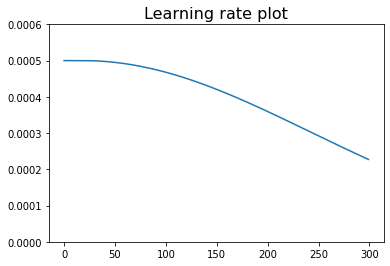

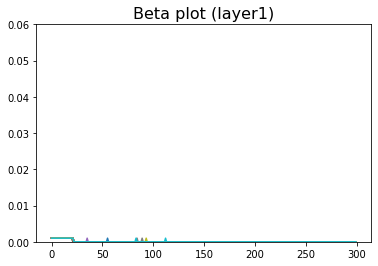

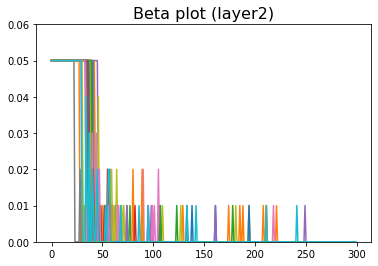

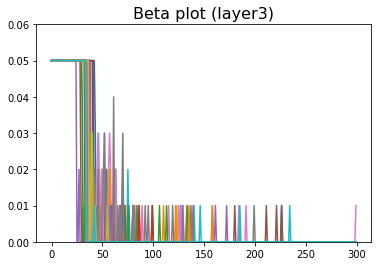

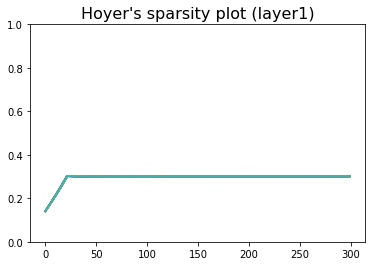

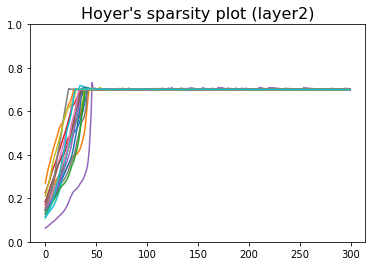

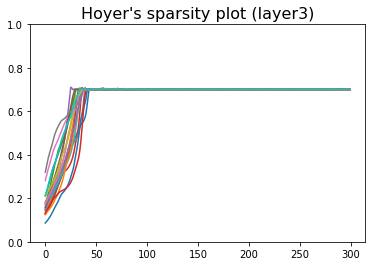

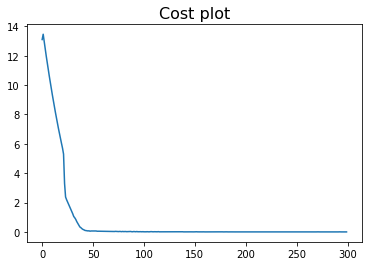

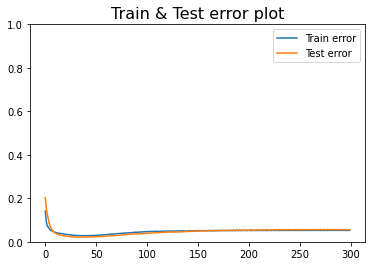


####################################################################


==> Training has been finished!

The code ran for 7 mins




In [ ]:
start_time = timeit.default_timer()

error_vd = [None]*n_hsp_cands
hsp_vd = [None]*n_hsp_cands

for i_tg in range(n_hsp_cands+1):
    
        
    ### (1) In case of a validation phase 
    if i_tg < n_hsp_cands:      
        vd_ts = 'Validation'
        # Target hsp
        hsp_tg = hsp_cands[i_tg]
        n_hsp_tg = len(hsp_tg)
        
        # First half
        train_x_set = train_x[:int(np.size(train_x,axis=0)/4)][:]
        train_y_set = train_y[:int(np.size(train_y,axis=0)/4)][:]
        # Secend half
        test_x_set = train_x[int(np.size(train_x,axis=0)/4):][:]
        test_y_set = train_y[int(np.size(train_y,axis=0)/4):][:]
        print("\n ****************************** Validation phase *******************************")
        print("# (",i_tg+1,"/",n_hsp_cands,") hsp candidate :",hsp_tg,"#")
        
    ### (2) In case of a test phase
    else:
        vd_ts = 'Test'
        i_selected = np.argmin(error_vd)
        hsp_tg = hsp_cands[i_selected]
        n_hsp_tg = len(hsp_tg) 

        train_x_set = train_x[:][:]
        train_y_set = train_y[:][:]
        test_x_set = test_x[:][:]
        test_y_set = test_y[:][:]
        print("\n ****************************** Test phase *******************************")
        print("############### ==> Selected hsp :",hsp_tg,"###############")

    # Training starts    
    with tf.Session(config=tf.ConfigProto(log_device_placement=False)) as sess:

        # Make a new results directory for the target
        hsp_tg_str=['0.%02d-'%(i*100) for i in hsp_tg]
        hsp_tg_str[-1]=hsp_tg_str[-1][:-1]
        hsp_tg_str=''.join(hsp_tg_str)

        directory_results = os.path.join(directory_save, r'%s_hsp_tg_%s'%(vd_ts,hsp_tg_str))
        if not os.path.exists(directory_results):
            os.makedirs(directory_results)        

        # beta_val, beta_flat, hsp_val, result_beta, result_hsp, result_lr, result_cost, result_train_err, result_test_err = init_savingVariables(n_hsp_tg)
        beta_val, beta_flat, hsp_val, result_beta, result_hsp, result_lr, result_cost, result_train_err, result_test_err, result_train_pct, result_test_pct = init_savingVariables(n_hsp_tg) 
        
        # Saver allows us to save and restore the Tensorflow model
        saver = tf.train.Saver()
        if os.path.exists(directory_results+'/saved_model.meta'):
            saver.restore(sess, directory_results+'/saved_model.ckpt')

        
        # To initialize all the variables in a TensorFlow program, you must explicitly call a special operation
        init = tf.global_variables_initializer()

        # run tensorflow variable initialization
        sess.run(init)


        # Start training
        for epoch in range(n_epochs):

            # Shuffle training data at the begining of each epoch
            n_samples = np.size(train_x_set, axis=0)
            
            # Begin annealing
            if epoch == 0:
                lr = lr_init
            elif decay_rate!=0 and (epoch+1)>begin_anneal:
                lr = max( lr_min, (-decay_rate*(epoch+1) + (1+decay_rate*begin_anneal)) * lr )

            cost_epoch=0.0
            
            # How many mini-batch iterations we need
            n_batches = int(np.ceil(n_samples/batch_size))
            
            # minibatch based training
            for batch in range(n_batches):
                first_sample = batch*batch_size
                last_sample = min((batch+1)*batch_size, n_samples)
                batch_x = train_x_set[first_sample:last_sample]
                batch_y = train_y_set[first_sample:last_sample]
  
                # Get cost and optimize the model
                cost_batch,_ = sess.run([cost,optimizer],{Lr:lr, X:batch_x, Y:batch_y, Beta:beta_flat, L2_REG:L2_reg})
                cost_epoch += cost_batch/n_batches

                # Weight sparsity control
                if mode=='layer':
                    for i in range(n_hsp_tg):
                        [hsp_val[i], beta_val[i]] = Hoyers_sparsity_control(mode, beta_lr[i], sess.run(w[i]), beta_val[i], max_beta[i], hsp_tg[i])
                    beta_flat = beta_val[:]

                elif mode=='node':
                    for i in range(n_hsp_tg):
                        [hsp_val[i], beta_val[i]] = Hoyers_sparsity_control(mode, beta_lr[i], sess.run(w[i]), beta_val[i], max_beta[i], hsp_tg[i])
                    # flatten beta_val (shape (3, 100) -> (300,))
                    beta_flat = [item for sublist in beta_val for item in sublist]

            # get train and test error
            train_pct_epoch=sess.run(mlp_layers[-1],{X:train_x,Y:train_y});
            train_ref=sess.run(Y,{X:train_x,Y:train_y});
            train_err_epoch = (np.square(train_ref - train_pct_epoch.flatten())).mean()
            
            test_pct_epoch=sess.run(mlp_layers[-1],{X:test_x,Y:test_y});
            test_ref=sess.run(Y,{X:test_x,Y:test_y});
            test_err_epoch = (np.square(test_ref - test_pct_epoch.flatten())).mean()

            # Save the results to array
            result_train_err=np.hstack([result_train_err,[train_err_epoch]])
            result_train_pct =np.vstack([result_train_pct,[train_pct_epoch.flatten()]])
            result_test_err=np.hstack([result_test_err,[test_err_epoch]])
            result_test_pct=np.vstack([result_test_pct,[test_pct_epoch.flatten()]])
            
            result_lr = np.hstack([result_lr,[lr]])
            result_cost = np.hstack([result_cost,[cost_epoch]])

            if mode=='layer':
                result_hsp=[np.vstack([result_hsp[i],[hsp_val[i]]]) for i in range(n_hsp_tg)]
                result_beta=[np.vstack([result_beta[i],[beta_flat[i]]]) for i in range(n_hsp_tg)]

            elif mode=='node':
                result_hsp=[np.vstack([result_hsp[i],[np.transpose(hsp_val[i])]]) for i in range(n_hsp_tg)]
                result_beta=[np.vstack([result_beta[i],[np.transpose(beta_val[i])]]) for i in range(n_hsp_tg)]

            # Print result at epoch 
            if ((epoch+1)%50==0):
                print("< Epoch", "{:02d}".format(epoch+1),"> Cost :", "{:.3f}".format(cost_epoch)\
                                                ,"/ Train err :", "{:.3f}".format(train_err_epoch),"/ ",vd_ts," err :","{:.3f}".format(test_err_epoch))
                print("             beta :",np.mean(np.swapaxes(result_beta,0,1)[-1][:][:],axis=1),"/ hsp :",np.mean(np.swapaxes(result_hsp,0,1)[-1][:][:],axis=1))

                
        print("")
        print("-> Error :", "{:.3f}".format(result_test_err[-1]))
        
            
        # Plot and save the figures
        # Plot the change of learning rate
        plt.figure()
        plt.title("Learning rate plot",fontsize=16)
        result_lr=result_lr[1:]
        plt.ylim(0.0, lr_init*1.2)
        plt.plot(result_lr)
 
        plt.savefig(directory_results+'/learning_rate.png')
        plt.show();

        if mode=='layer':
            # Plot the change of beta value
            print("")
            plt.figure()
            for i in range(n_hsp_tg):
                print("")
                plt.title("Beta plot",fontsize=16)
                result_beta[i]=result_beta[i][1:]
                plt.plot(result_beta[i], label='layer%d'%(i+1))
                plt.ylim(0.0, np.max(max_beta)*1.2)
            plt.legend(loc='best')
         
            plt.savefig(directory_results+'/beta.png')
            plt.show();

            # Plot the change of Hoyer's sparsity level
            print("")
            plt.figure()
            for i in range(n_hsp_tg):
                print("")
                plt.title("Hoyer's sparsity plot",fontsize=16)
                result_hsp[i]=result_hsp[i][1:]
                plt.plot(result_hsp[i], label='layer%d'%(i+1))
                plt.ylim(0.0, 1.0)
            plt.legend(loc='best')
 
            plt.savefig(''.join([directory_results, '/hsp_final', 
                            ''.join(['_{:.3f}'.format(np.mean(result_hsp[i][-1])) for i in range(n_hsp_tg)]),'.png']))
            plt.show();

        elif mode=='node':
            # Plot the change of beta value
            print("")
            for i in range(n_hsp_tg):
                plt.figure()
                plt.title("Beta plot (layer"+str(i+1)+")",fontsize=16)
                result_beta[i]=result_beta[i][1:]
                plt.plot(result_beta[i])
                plt.ylim(0.0, np.max(max_beta)*1.2)
                
                plt.savefig(directory_results+'/beta_layer'+str(i+1)+'.png')
                plt.show();

            # Plot the change of Hoyer's sparsity level
            print("")         
            for i in range(n_hsp_tg):
                plt.figure()
                plt.title("Hoyer's sparsity plot (layer"+str(i+1)+")",fontsize=16)
                result_hsp[i]=result_hsp[i][1:]
                plt.plot(result_hsp[i])
                plt.ylim(0.0, 1.0)
           
                plt.savefig(''.join([directory_results, '/hsp_layer'+str(i+1)+'_final', 
                                ''.join(['_{:.3f}'.format(np.mean(result_hsp[i][-1])) for i in range(n_hsp_tg)]),'.png']))
                plt.show();
        
        # Plot the change of cost
        plt.figure()
        plt.title("Cost plot",fontsize=16)
        result_cost=result_cost[1:]
        plt.plot(result_cost)
        
        plt.savefig(directory_results+'/cost.png')
        plt.show();


        # Plot train & test error
        plt.figure();
        plt.title("Train & Test error plot",fontsize=16)
        result_train_err=result_train_err[1:]
        plt.plot(result_train_err, label='Train error')
        result_test_err=result_test_err[1:]
        plt.plot(result_test_err, label='%s error'%vd_ts)
        plt.ylim(0.0, 1.0)
        plt.legend(loc='upper right')
        
        plt.savefig(directory_results+'/error_'+"tr{:.4f}_ts{:.4f}".format(result_train_err[-1],result_test_err[-1])+'.png')
        plt.show();
            
            
        # save results as .mat file
        sio.savemat(directory_results+"/result_learningrate.mat", mdict={'lr': result_lr})
        sio.savemat(directory_results+"/result_cost.mat", mdict={'cost': result_cost})
        sio.savemat(directory_results+"/result_train_err.mat", mdict={'trainErr': result_train_err})
        sio.savemat(directory_results+"/result_test_err.mat", mdict={'testErr': result_test_err})
        sio.savemat(directory_results+"/result_beta.mat", mdict={'beta': result_beta})
        sio.savemat(directory_results+"/result_hsp.mat", mdict={'hsp': result_hsp})
        sio.savemat(directory_results+"/result_weight.mat", mdict={'weight': sess.run(w)})
        sio.savemat(directory_results+"/result_bias.mat", mdict={'bias': sess.run(b)})
        sio.savemat(directory_results+"/result_train_pct.mat", mdict={'trainPct': result_train_pct})
        sio.savemat(directory_results+"/result_test_pct.mat", mdict={'testPct': result_test_pct})
        sio.savemat(directory_results+"/result_train_ref.mat", mdict={'trainRef': train_ref})
        sio.savemat(directory_results+"/result_test_ref.mat", mdict={'testRef': test_ref})
        
        # If it was validation phase
        if i_tg < n_hsp_cands: 
            plt.close('all')
            error_vd[i_tg] = result_test_err[-1]
            hsp_vd[i_tg] = np.mean(np.swapaxes(result_hsp,0,1)[-1],axis=1)
   
          
        
        end_time = timeit.default_timer()

        print('\n####################################################################\n\n')
        print('==> Training has been finished!\n')
        print('The code ran for %d mins' %((end_time-start_time)/60)+'\n\n')


## 2-2-9. Save parameters and summary

In [ ]:
f = open(directory_save+"/parameters_summary.txt",'w') 
f.write('mode : '+str(mode)+'\n')
f.write('optimizer_algorithm : '+str(optimizer_algorithm)+'\n')
f.write('layer_activation : '+str(layer_activation)+'\n')
f.write('n_epochs : '+str(n_epochs)+'\n')
f.write('batch_size : '+str(batch_size)+'\n')
f.write('lr_init : '+str(lr_init)+'\n')
f.write('lr_min : '+str(lr_min)+'\n')
f.write('begin_anneal : '+str(begin_anneal)+'\n')
f.write('decay_rate : '+str(decay_rate)+'\n')
f.write('L2_reg : '+str(L2_reg)+'\n')
f.write('max_beta : '+str(max_beta)+'\n')
f.write('beta_lr : '+str(beta_lr)+'\n')
f.write('---\n')
for i_tg in range(n_hsp_cands):
    f.write('('+str(i_tg+1)+'/'+str(n_hsp_cands)+') tg :'+str(hsp_cands[i_tg])+'/ hsp : '+str(hsp_vd[i_tg])+'- val error : '+"{:.3f}".format(error_vd[i_tg])+'\n')
f.write('==> Selected tg :'+str(hsp_cands[i_selected])+'/ hsp : '+str(np.mean(np.swapaxes(result_hsp,0,1)[-1][:][:],axis=1))+'- ts error : '+"{:.3f}".format(result_test_err[-1])+'\n')
f.write('\n The code ran for %d mins' %((end_time-start_time)/60)+'\n\n')
f.close()


# 3-1.  Interpretation of the results from the DNN 

## 3-1-1. Load the result files


In [ ]:
import matplotlib.pyplot as plt
import numpy as np  # Simplification
import scipy.io as sio
import os

trvld_err = sio.loadmat('%s/result_train_err.mat' % (directory_results))['trainErr']  # load "error" values
pct_trvld = sio.loadmat('%s/result_train_pct.mat' % (directory_results))['trainPct']  # load "predcited emotion scores" 
train_y = sio.loadmat('%s/result_train_ref.mat' % (directory_results))['trainRef']  # load "Rated emotion scores" 

ts_err = sio.loadmat('%s/result_test_err.mat' % (directory_results))['testErr']  # load "error" values
pct_tst = sio.loadmat('%s/result_test_pct.mat' % (directory_results))['testPct']  # load "predicted emotion scores" 
test_y = sio.loadmat('%s/result_test_ref.mat' % (directory_results))['testRef']  # load "Rated emotion scores"

hsp_vals = sio.loadmat('%s/result_hsp.mat' % (directory_results))['hsp']  # load "Hoyer sparisty levels" 
weights = sio.loadmat('%s/result_weight.mat' % (directory_results))['weight']  # load "trained weight parameters"

nepoch = ts_err.shape[1]

## 3-1-2. Calculation of Correlation coefficient bewteen rated and predcited emotion responses

In [ ]:
tr_cc = np.zeros((nepoch));  ts_cc = np.zeros((nepoch));

for ii in range(nepoch):
    tr_r = np.corrcoef(pct_trvld[ii,:].flatten(),train_y.flatten());
    ts_r = np.corrcoef(pct_tst[ii,:].flatten(),test_y.flatten());
    tr_cc[ii] =tr_r[1,0];
    ts_cc[ii] = ts_r[1,0];

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


## 3-1-3. Plots of the DNN results

The convergence of the training and test correlation coefficients should be checked

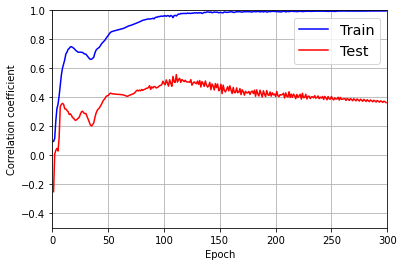

In [ ]:
## Plotting DNNP results
t1 = np.arange(0, nepoch, 1)


# Training/test learning curves of the correlation coefficient 
plt.figure(0);
plt.plot(t1, tr_cc.flatten(), 'b', label ='Train')
plt.plot(t1, ts_cc.flatten(), 'r', label ='Test')
plt.axis([0, nepoch, -0.5, 1]); plt.grid(True);
plt.xlabel('Epoch'); plt.ylabel('Correlation coefficient')
plt.legend(loc='best', fontsize='x-large')
plt.xlim([0,nepoch]) 
plt.show()

The sparsity levels are converged to the target sparsity levels of each hidden layer.

(3, 300, 20)


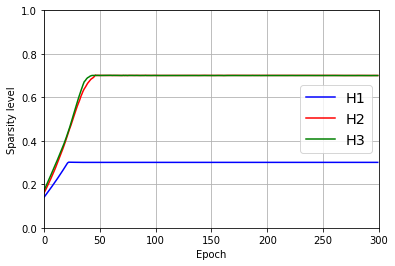

In [ ]:
# Sparsity changes over epoch

print(hsp_vals.shape)

plt.figure(1);
plt.plot(t1, np.mean(hsp_vals[0,t1,:],axis=1), 'b',label ='H1'); # hidden layer 1
plt.plot(t1,  np.mean(hsp_vals[1,t1,:],axis=1), '-r',label ='H2'); # hidden layer 2
plt.plot(t1,  np.mean(hsp_vals[2,t1,:],axis=1), '-g',label ='H3'); # hidden layer 3
plt.axis([0, nepoch, 0, 1]);plt.grid(True); 
plt.xlabel('Epoch'); plt.ylabel('Sparsity level')
plt.legend(loc='best', fontsize='x-large')
plt.show()

The following code is to check patterns of the estimated emotion response from training and test data.


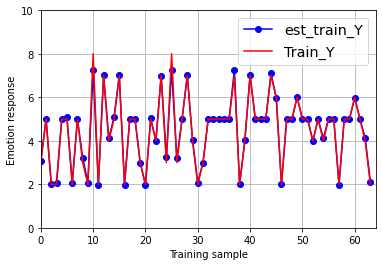

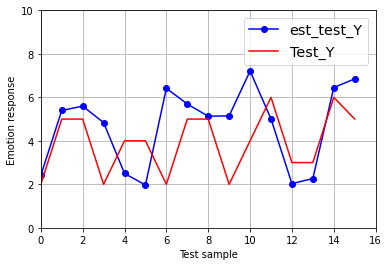

In [ ]:
# Plotting of emotion responses and estimated responses obtained from training data

plt.figure(2);

t2 = np.arange(0, pct_trvld.shape[1], 1)

pct_train_y = pct_trvld[nepoch-1,:].flatten()

plt.plot(t2, pct_train_y*10, '-ob', label ='est_train_Y')
plt.plot(t2, train_y.flatten()*10, '-r', label ='Train_Y')
plt.axis([0, pct_trvld.shape[1], 0, 10]); plt.grid(True)

plt.xlabel('Training sample'); plt.ylabel('Emotion response')
plt.legend(loc='best', fontsize='x-large')

plt.figure(5);

t3 = np.arange(0, pct_tst.shape[1], 1); 
pct_test_y = pct_tst[nepoch-1,:].flatten();

plt.plot(t3, pct_test_y*10, '-ob', label ='est_test_Y');
plt.plot(t3, test_y.flatten()*10, '-r', label ='Test_Y');
plt.axis([0, pct_tst.shape[1], 0, 10]); plt.grid(True);

plt.xlabel('Test sample'); plt.ylabel('Emotion response');
plt.legend(loc='best', fontsize='x-large');

plt.show()


## 3-1-4. Weight feature map interpretation



### How to represent weight features?

In [ ]:
import nibabel as nib
from nilearn import image
import scipy.stats # This module contains a large number of probability distributions as well as a growing library of statistical functions.

maskimage_mem = image.load_img(os.path.join('mask_map.nii'))

maskimage_mem

mask3d = maskimage_mem.get_data()

# "weights" variable in a cell structure form, which consist of four matrixces [input to output layer] in each cell 
# because this tutorital code uses three-layer DNN, 
W1 = weights[0,0]; # input to 1st
W2 = weights[0,1]; # 1st to 2nd
W3 = weights[0,2]; # 3rd to 4th 
W4 = weights[0,3]; # 4th to last 

print(W1.shape)
print(W2.shape)
print(W3.shape)
print(W4.shape)

(55417, 20)
(20, 20)
(20, 20)
(20, 1)


<ipython-input-22-3e3800cf1001>:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask3d = maskimage_mem.get_data()


### 1st hidden layer: Spatial patterns of weight features 

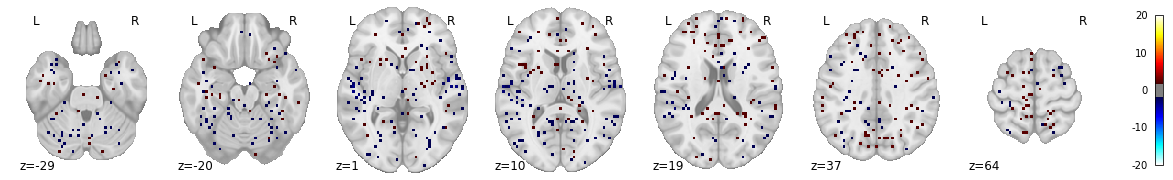

In [ ]:
from nilearn import plotting

xdim = 53; ydim = 63; zdim = 46
tg_node = 10

Wf = W1;  z_Wf = scipy.stats.zscore(Wf,axis=0,ddof=1)

Wf_3dmap = np.zeros((xdim,ydim,zdim))
Wf_3dmap[np.nonzero(mask3d)] = z_Wf[:,tg_node]
Wf_map_mem = nib.Nifti1Image(Wf_3dmap,maskimage_mem.affine)

plotting.plot_stat_map(Wf_map_mem,display_mode="z",threshold = 1.96,vmax=20)

### 2nd hidden layer: Spatial patterns of weight features 

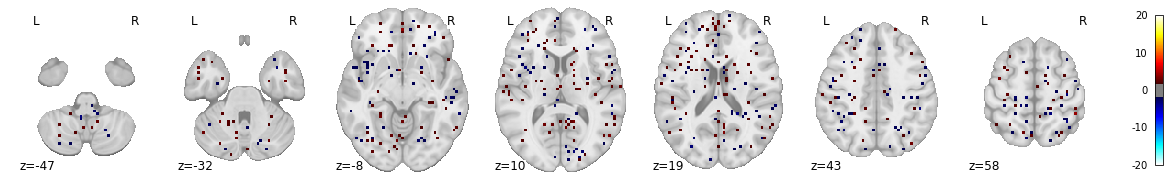

In [ ]:
xdim = 53; ydim = 63; zdim = 46
tg_node = 3

W2f = np.inner(W1,W2);  z_W2f = scipy.stats.zscore(W2f,axis=0,ddof=1)

W2f_3dmap = np.zeros((xdim,ydim,zdim))
W2f_3dmap[np.nonzero(mask3d)] = z_W2f[:,tg_node]
W2f_map_mem = nib.Nifti1Image(W2f_3dmap,maskimage_mem.affine)

plotting.plot_stat_map(W2f_map_mem,display_mode="z",threshold = 1.96,vmax=20)

### 3rd hidden layer: Spatial patterns of weight features 

(55417, 20)


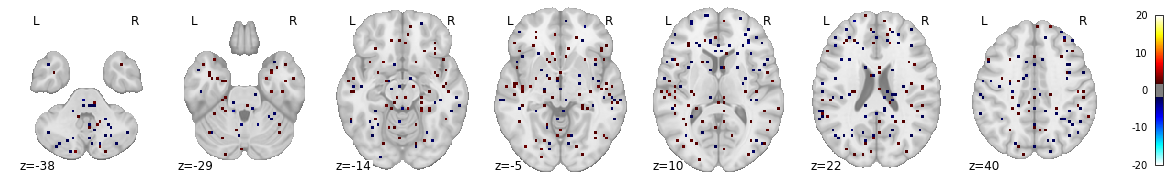

In [ ]:
xdim = 53; ydim = 63; zdim = 46
tg_node = 0

W3f = np.inner(W2f,W3);  z_W3f = scipy.stats.zscore(W3f,axis=0,ddof=1)
print(W3f.shape)
W3f_3dmap = np.zeros((xdim,ydim,zdim))
W3f_3dmap[np.nonzero(mask3d)] = z_W3f[:,tg_node]
W3f_map_mem = nib.Nifti1Image(W3f_3dmap,maskimage_mem.affine)

plotting.plot_stat_map(W3f_map_mem,display_mode="z",threshold = 1.96,vmax=20)

### Output hidden layer: Spatial patterns of weight features 

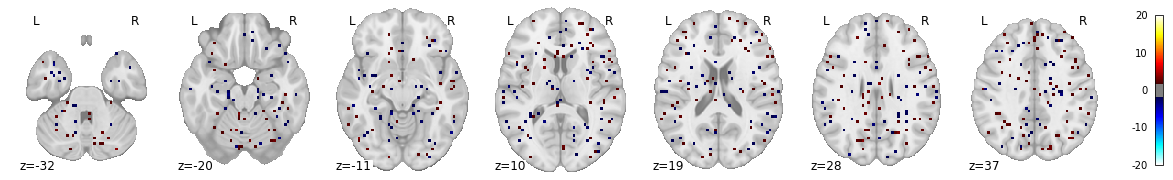

In [ ]:
xdim = 53; ydim = 63; zdim = 46

W4f = np.inner(W3f,np.transpose(W4)).flatten();  
z_W4f = scipy.stats.zscore(W4f,axis=0,ddof=1)

W4f_3dmap = np.zeros((xdim,ydim,zdim))
W4f_3dmap[np.nonzero(mask3d)] = z_W4f
W4f_map_mem = nib.Nifti1Image(W4f_3dmap,maskimage_mem.affine)

plotting.plot_stat_map(W4f_map_mem,display_mode="z",threshold = 1.96,vmax=20)